In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from collections import deque
import scipy
from scipy import ndimage
import pandas as pd
import matplotlib.gridspec as gridspec
import os
import shutil
import seaborn
import sklearn

import imageio; 
from IPython.display import Video; 

#%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
#imageio.mimwrite('flow_x.mp4', out_video[:, 50:-50, 50:-50], fps=25); 
#Video('flow_x.mp4', width=480, height=720)

### Obligatory axes direction test
I always perform this to make sure I have the exact orientation of axes, order of argument lists, etc.

(0,0) = 100.0
(0,9) = 122.5
(9,0) = 190.0
(9,9) = 212.5


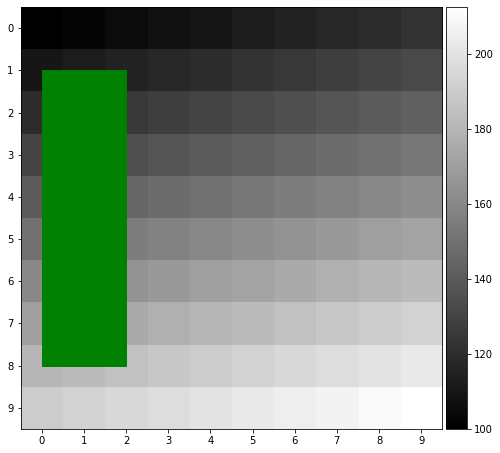

In [4]:
xs, ys = np.meshgrid(np.arange(0, 25, step=2.5), np.arange(100,200, step=10))
fig,ax = plt.subplots(figsize=(8,8))
pixels = xs+ys
im = ax.imshow(pixels, cmap='gray')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.add_patch(Rectangle((0,1), 2, 7, color='g'))
ax.set_xticks(range(0,10))
ax.set_yticks(range(0,10))
print(f'(0,0) = {pixels[0][0]}')
print(f'(0,9) = {pixels[0][9]}')
print(f'(9,0) = {pixels[9][0]}')
print(f'(9,9) = {pixels[9][9]}')
_ = _

-----

### Constants for processing and analyzing the video

In [167]:
every_nth = 5
hist_bin_count = 20
magic_threshold = 0.3
clip_flow_mag = 1.0
hist_bin_edges = np.arange(-clip_flow_mag, clip_flow_mag, 2*clip_flow_mag/30)    


LIGHT_GREEN = '#aaffaa'
LIGHT_GRAY = '#cccccc'
ASCII = {
    'arrow_left': u'\u2190',
    'arrow_right': u'\u2192',
    'arrow_up': u'\u2191',
    'arrow_down': u'\u2193',
    'checkmark': u'\u2713'
}


-----

In [222]:
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

def read_next_frame(video_obj, resize_max_dim=720):
    ret, next_frame = video_obj.read()
    if not ret:
        return None, None, None
    
        
    max_dim = max(next_frame.shape)
    scale_dim = resize_max_dim / max_dim
    new_dims = tuple([int(next_frame.shape[i] * scale_dim) for i in [0,1]])
    resized_frame = cv2.resize(next_frame, new_dims[::-1], interpolation=0)
    
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (7,7), 0)
    tracked_pts = cv2.goodFeaturesToTrack(gray_frame, mask=None, **feature_params)
        
    # Reverse RBG channels of color frame
    return next_frame[:,:,::-1], gray_frame, tracked_pts

        
# Create random colors
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it
cap = cv2.VideoCapture('resin_timelapse_test_lores.avi')
first_color_frame, first_gray_frame, p0 = read_next_frame(cap)

# Use this as a circular buffer to hold frames
frame_buffer = deque([])
convert_to_gray = True

for _ in range(60*25):
    ret, next_frame = cap.read()

# Each element is one pair of frames and it flow vectors
all_frames_data = []
def append_blank_frame_data():
    all_frames_data.append({
        'frame': None,
        'gray_frame': None,
        'frame_index': None,
        'prev_good_pts': None,
        'curr_good_pts': None,
        'norm_flow_vects': None,
        'flow_magnitudes': None,
        'x_mags': None,
        'y_mags': None,
        'flow_bucket_counts': None,
        'status_str': None
    })
    
    return all_frames_data[-1]
    

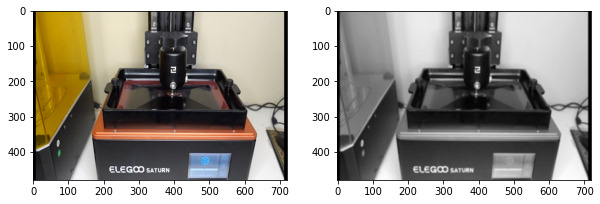

In [223]:
# Confirm resizing, grayscale conversion
fig,axs = plt.subplots(1,2, figsize=(10,6))
axs[0].imshow(first_color_frame)
axs[1].imshow(first_gray_frame, cmap='gray')

In [246]:
def calc_flow_buckets(fdata):
    buckets = np.zeros(shape=(2,3))
    X,Y = 0,1
    buckets[X][0] = sum(fdata['x_mags'] <= -magic_threshold)
    buckets[X][2] = sum(fdata['x_mags'] >= magic_threshold)
    buckets[X][1] = len(fdata['x_mags']) - (buckets[X][0] + buckets[X][2])
                        
    buckets[Y][0] = sum(fdata['y_mags'] <= -magic_threshold)
    buckets[Y][2] = sum(fdata['y_mags'] >= magic_threshold)
    buckets[Y][1] = len(fdata['y_mags']) - (buckets[Y][0] + buckets[Y][2])
                        
    return buckets
 
def determine_status(flow_buckets, min_clust_size=5):
    X,Y = 0, 1
    if max(flow_buckets[X][0], flow_buckets[X][2]) > min_clust_size:
        print('WARNING: large X/horizontal flows!')
        return 'HORIZ'
    if flow_buckets[Y][1] < min_clust_size:
        print('WARNING: too few stationary Y/vertical flows')
        return 'Y-UNSTABLE'
    if min(flow_buckets[Y][0], flow_buckets[Y][2]) > min_clust_size:
        print('WARNING: too many vertical flows in both directions')
        return 'Y-BOTHDIR'
    if flow_buckets[Y][0] > min_clust_size:
        return 'UP'
    elif flow_buckets[Y][2] > min_clust_size:
        return 'DOWN'
    else:
        return 'STATIONARY'
    

In [227]:
total_frames = 1
frame_ct = 0
while(cap.isOpened()):
        
    next_frame, gray_frame, p0 = read_next_frame(cap)
    if next_frame is None:
        break
        
    frame_buffer.append(gray_frame)
    if len(frame_buffer) < every_nth:
        continue
        
    if len(frame_buffer) > every_nth:
        _ = frame_buffer.popleft()
        
    frame_ct += 1
    if frame_ct % every_nth > 0:
        continue
        
    fdata = append_blank_frame_data()
    fdata['frame'] = next_frame.copy()
    fdata['gray_frame'] = frame_buffer[-1].copy()
    fdata['frame_index'] = frame_ct
        
    # Calculate Optical Flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(frame_buffer[0],
                                           frame_buffer[-1],
                                           p0,
                                           None,
                                           **lk_params)
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    # Draw the tracks
    n_pts = len(good_new)
    fdata['prev_good_pts'] = np.zeros(shape=(n_pts, 2))
    fdata['curr_good_pts'] = np.zeros(shape=(n_pts, 2))
    fdata['norm_flow_vects'] = np.zeros(shape=(n_pts, 2))
    fdata['flow_magnitudes'] = np.zeros(shape=(n_pts, 1))
    
    flow_mags = []
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        fdata['prev_good_pts'][i, :] = old
        fdata['curr_good_pts'][i, :] = new
        flow_mag = np.linalg.norm(new - old)
        fdata['norm_flow_vects'][i, :] = (new - old) / flow_mag
        flow_mags.append(flow_mag)
        
    # Find the 95th percentile flow vector, normalize to that.
    max_mag = np.percentile(flow_mags, 95)
    fdata['flow_magnitudes'][:, 0] = flow_mags
    
    abs_flows = fdata['norm_flow_vects'] * fdata['flow_magnitudes']
    fdata['x_mags'] = abs_flows[:, 0]
    fdata['y_mags'] = abs_flows[:, 1]
    
    hist_counts, hist_edges = np.histogram(fdata['y_mags'], bins=hist_bin_count)
    p0 = cv2.goodFeaturesToTrack(gray_frame, mask=None, **feature_params)
    
    fdata['flow_bucket_counts'] = calc_flow_buckets(fdata)
    fdata['status_str'] = determine_status(fdata['flow_bucket_counts'])
    
    if frame_ct % 200 == 0:
        print('Finished', frame_ct)

Finished 200
Finished 400
Finished 600
Finished 800
Finished 1000
Finished 1200
Finished 1400
Finished 1600
Finished 1800
Finished 2000
Finished 2200
Finished 2400
Finished 2600
Finished 2800
Finished 3000
Finished 3200
Finished 3400
Finished 3600
Finished 3800
Finished 4000
Finished 4200
Finished 4400
Finished 4600
Finished 4800
Finished 5000
Finished 5200
Finished 5400
Finished 5600
Finished 5800
Finished 6000
Finished 6200
Finished 6400
Finished 6600
Finished 6800
Finished 7000


In [254]:
def draw_frame(all_fdata, frm_num, opacity=0.3, crop_pixels=50, min_clust_size=5):
    '''
    In this functional call: frm_num refers to the index of the data in all_fdata. 
    But each fdata object has its own "frame_index" which is the actual frame
    number within the original video file (we may only be using every fifth
    frame for our calcs.
    '''
    fig = plt.figure(tight_layout=True, figsize=(16,9))
    
    gs = gridspec.GridSpec(7, 5)

    axs = []
    axs.append(fig.add_subplot(gs[0:5, 0:3]))
    axs.append(fig.add_subplot(gs[5:7, 0]))
    axs.append(fig.add_subplot(gs[5:7, 1]))
    axs.append(fig.add_subplot(gs[5:7, 2]))
    axs.append(fig.add_subplot(gs[0:5, 3]))
        
    fdata = all_fdata[frm_num]
    
    this_frame = fdata['frame'][crop_pixels:-crop_pixels, crop_pixels:-crop_pixels]
    opacity_img = opacity * this_frame / 256.0 + (1-opacity)
    img_dim = max(this_frame.shape)
    axs[0].imshow(opacity_img)
    
    axs[0].text(10, 30, f'Frame#: {fdata["frame_index"]} (i={frm_num})', fontsize=20)
    axs[0].text(10, 60, f'Status: {fdata["status_str"]}', fontsize=20)
        
    xlims,ylims = axs[0].get_xlim(), axs[0].get_ylim()
    max_ylim=30
    for p in range(len(fdata['curr_good_pts'])):
        
        curr_point = fdata['curr_good_pts'][p] - crop_pixels
        prev_point = fdata['prev_good_pts'][p] - crop_pixels
        norm_flow = fdata['norm_flow_vects'][p]
        
        flow_mag = np.clip(fdata['flow_magnitudes'][p], -clip_flow_mag, clip_flow_mag)
        flow_draw = norm_flow * (flow_mag / clip_flow_mag) * (img_dim / 10) 
        i=0
        axs[i].add_patch(Circle((curr_point[0], curr_point[1]), radius=3, color='r'))
        axs[i].arrow(*prev_point, *flow_draw, color='r',  head_width=5 if abs(flow_mag)>magic_threshold else 0)
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
        axs[i].set_xlim(*xlims)
        axs[i].set_ylim(*ylims)
        
        i = 1
        axs[i].hist(fdata['x_mags'], bins=hist_bin_edges, color='b')
        axs[i].plot([-magic_threshold, -magic_threshold], [0, max_ylim], 'g-.')
        axs[i].plot([magic_threshold, magic_threshold], [0, max_ylim], 'g-.')
        axs[i].set_xlim(-clip_flow_mag*1.1, clip_flow_mag * 1.1)
        axs[i].set_xlabel('X-flow Magnitude')
        axs[i].set_ylabel('Histogram Counts')
        
        i = 2
        axs[i].hist(fdata['y_mags'], bins=hist_bin_edges, color='b')
        axs[i].set_xlim(-clip_flow_mag*1.1, clip_flow_mag * 1.1)
        axs[i].plot([-magic_threshold, -magic_threshold], [0, max_ylim], 'g-.')
        axs[i].plot([magic_threshold, magic_threshold], [0, max_ylim], 'g-.')
        axs[i].set_xlabel('Y-flow Magnitude')
        axs[i].set_ylabel('Histogram Counts')
       
        i = 3
        axs[i].set_xlim(0, 120)
        axs[i].set_ylim(0, 120)
        axs[i].set_axis_off()
        
    '''
    [
      [ x_neg, x_zero, x_pos ],
      [ y_neg, y_zero, y_pos ],
    '''
    x_vals = fdata['flow_bucket_counts'][0, :]
    y_vals = fdata['flow_bucket_counts'][1, :]

    colors = {}
    text = {}

    error = False
    colors['xl'] = 'white'
    colors['xc'] = LIGHT_GRAY
    colors['xr'] = 'white'
    if x_vals[0] >= min_clust_size:
        colors['xl'] = 'red'
        text['xc'] = '!'
        error = True
    elif x_vals[2] >= min_clust_size:
        colors['xr'] = 'red'
        text['xc'] = '!'
        error = True
    else:
        colors['xc'] = LIGHT_GRAY
        text['xc'] = '-'


    # Default
    colors['yu'] = 'white'
    colors['yc'] = LIGHT_GRAY
    colors['yd'] = 'white'
    text['yc'] = '-'

    if y_vals[1] < min_clust_size:
        error = True
        colors['yc'] = 'red'
        text['yc'] = '?'

        if y_vals[0] > min_clust_size:
            colors['yd'] = 'red'

        if y_vals[2] > min_clust_size:
            colors['yu'] = 'red'
    else:
        if y_vals[0] > min_clust_size and y_vals[0] > y_vals[2]:
            colors['yd'] = LIGHT_GREEN
            colors['yc'] = LIGHT_GREEN
            text['yc'] = ASCII['checkmark']

        elif y_vals[2] > min_clust_size:
            colors['yu'] = LIGHT_GREEN
            colors['yc'] = LIGHT_GREEN
            text['yc'] = ASCII['checkmark']

    # horizontal X-boxes
    axs[i].add_patch(Rectangle((20, 90), 20, 20, edgecolor='black', facecolor=colors['xl'], linewidth=1.5))
    axs[i].add_patch(Rectangle((40, 90), 20, 20, edgecolor='black', facecolor=colors['xc'], linewidth=1.5))
    axs[i].add_patch(Rectangle((60, 90), 20, 20, edgecolor='black', facecolor=colors['xr'], linewidth=1.5))

    # vertical Y-boxes
    axs[i].add_patch(Rectangle((40,10), 20, 20, edgecolor='black', facecolor=colors['yu'], linewidth=1.5))
    axs[i].add_patch(Rectangle((40,30), 20, 20, edgecolor='black', facecolor=colors['yc'], linewidth=1.5))
    axs[i].add_patch(Rectangle((40,50), 20, 20, edgecolor='black', facecolor=colors['yd'], linewidth=1.5))

    axs[i].text(10, 102, 'X', horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)
    axs[i].text(30, 102, ASCII['arrow_left'], horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)
    axs[i].text(50, 102, text['xc'], horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)
    axs[i].text(70, 102, ASCII['arrow_right'], horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)

    # Y-axis is from the top pointing down (positive values indicate lower on the image)
    axs[i].text(30, 40, 'Y', horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)
    axs[i].text(50, 20, ASCII['arrow_down'], horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)
    axs[i].text(50, 40, text['yc'], horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)
    axs[i].text(50, 60, ASCII['arrow_up'], horizontalalignment='center', verticalalignment='center_baseline', fontsize=25)

            
    i = 4
    axs[i].plot([0, 100], [375, 375], lw=2, c='black')
    axs[i].text(30, 390, 'Frame#', fontsize=15, horizontalalignment='right')
    
    axs[i].set_xlim(-10, 110)
    axs[i].set_ylim(-10, 410)

    # Show last N frames results
    N = 20
    
    for h in range(N):
        hist_fdata = all_fdata[frm-h]
        stat = hist_fdata['status_str']
        if stat.lower() == 'up':
            color = LIGHT_GREEN
            txt = ASCII['arrow_up']
        elif stat.lower() == 'down':
            color = '#aaaacc'
            txt = ASCII['arrow_down']
        elif stat.lower() == 'stationary':
            color = LIGHT_GRAY
            txt = '-'
        else:
            color = 'red'
            txt = '?'

        box_sz = 15
        box_ll_corner = (40, 370 - box_sz*(h+1))
        axs[i].axis('off')
        axs[i].add_patch(Rectangle(box_ll_corner, box_sz, box_sz, color=color))

        axs[i].text(box_ll_corner[0]+box_sz/2,
                    box_ll_corner[1]+box_sz/2,
                    txt,
                    fontsize=box_sz,
                    horizontalalignment='center',
                    verticalalignment='center')

        axs[i].text(box_ll_corner[0]-box_sz/2,
                    box_ll_corner[1]+box_sz/2,
                    f'{hist_fdata["frame_index"]}',
                    fontsize=box_sz,
                    horizontalalignment='right',
                    verticalalignment='center')

    return fig, axs
    

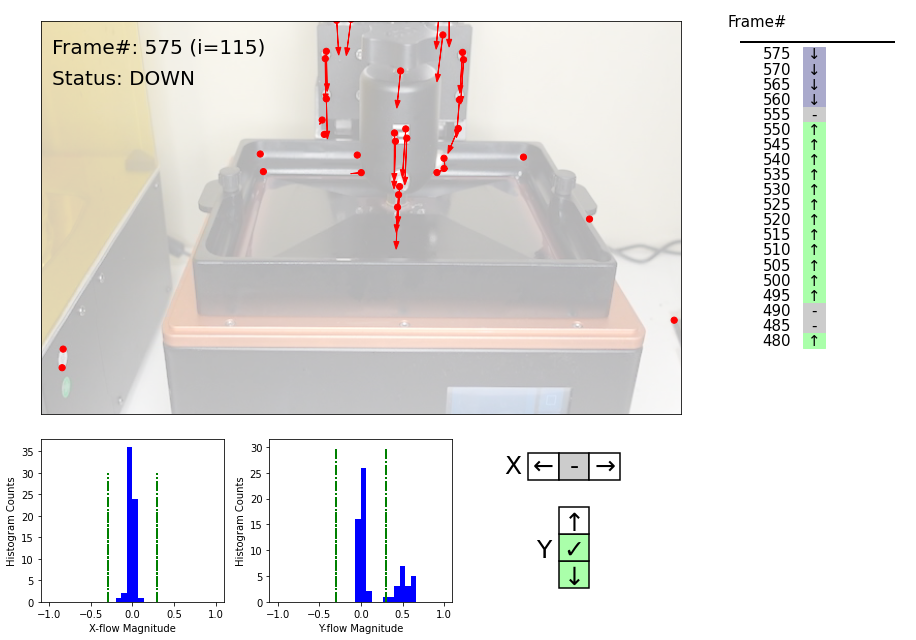

In [255]:
# Using fake data for the flow_buckets.
# Test calc on frame that has known downward vel
frm = 115

_ = draw_frame(all_frames_data, frm)

In [239]:
max_axes=3

all_figures = {}
out_dir = './saved_figs'
import shutil
shutil.rmtree(out_dir, ignore_errors=True)
os.makedirs(out_dir, exist_ok=True)

for f,fdata in enumerate(all_frames_data):
    all_figures[f] = draw_frame(all_frames_data[f], max_axes=max_axes)[0]
    all_figures[f].savefig(os.path.join(out_dir, f'frame_{f:04d}'), transparent=False, facecolor='white')
    plt.close(all_figures[f])
    
_ = draw_frame(all_frames_data[f], max_axes=max_axes)
  

TypeError: draw_frame() got an unexpected keyword argument 'max_axes'

In [ ]:
import subprocess

orig_dir = os.getcwd()
try:
    os.chdir(out_dir)
    out = subprocess.check_output([
        'ffmpeg',
        '-framerate', '8',
        '-i', f'frame_%04d.png',
        '-r', '30',
        '-pix_fmt', 'yuv420p',
        f'../flow_video_{max_axes}.mp4'
    ])
    print(out)
except:
    os.chdir(orig_dir)
    
    

## 1D Clustering Experiment
Man, clustering is a pain even in this simple example

[[-0.00806634]
 [ 0.00755596]]


-0.0015612661039334475

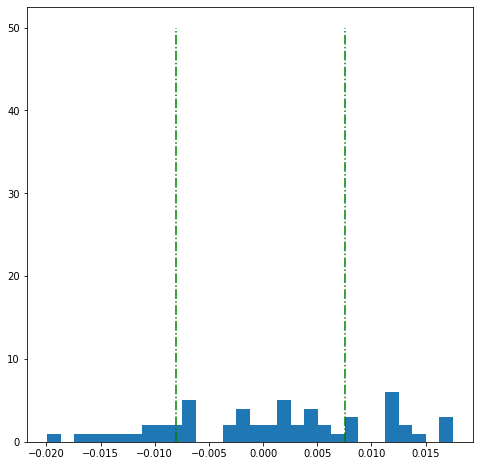

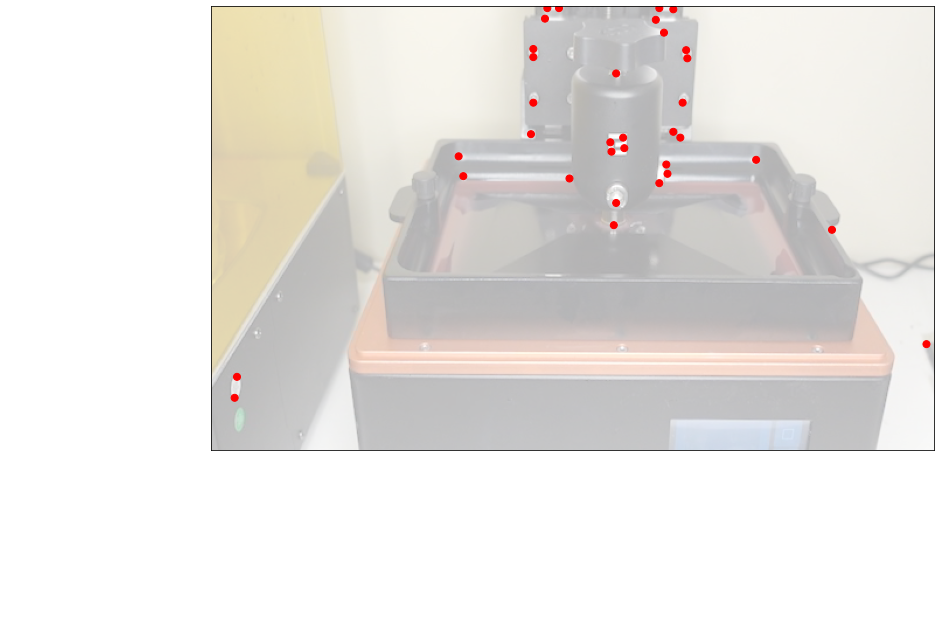

In [54]:
import sklearn.cluster
def compute_cluster_ymags(mags_array, n_clust=2):
    km = sklearn.cluster.KMeans(n_clust)
    km.fit(mags_array.reshape((-1, 1)))
    return km
    
    
frm = 5
n_clust = 2
y_mags = np.sort(all_frames_data[frm]['y_mags'])[4:-4]
y_mags = y_mags.reshape((-1, 1))
km_obj = compute_cluster_ymags(y_mags, n_clust=n_clust)
fig,ax = plt.subplots(figsize=(8,8))
ax.hist(y_mags, bins=30)
print(km_obj.cluster_centers_)
for ctr in km_obj.cluster_centers_:
    ax.plot([ctr, ctr], [0, 50], 'g-.')
    
draw_frame(all_frames_data[frm])
    
km_obj.score(y_mags)

In [ ]:
km

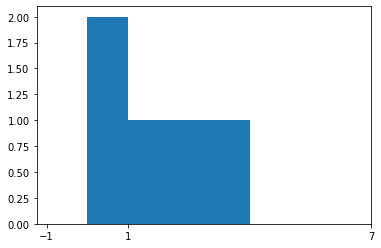

In [250]:
fig,ax = plt.subplots()
ax.hist([0,0,1,2,3], [-1,0,1,2,3,4])
ax.set_xticks([-1, 1, 7])

In [49]:
 
def draw_slider_plot(frm):
    if frm not in all_figures: 
        fig,axs = draw_frame(all_frames_data[frm], max_axes=5)
        all_figures[frm] = fig
    all_figures[frm].show()
 
widgets.interact(draw_slider_plot, frm=(0, len(all_frames_data)-1, 1))

interactive(children=(IntSlider(value=711, description='frm', max=1423), Output()), _dom_classes=('widget-inte…

<function __main__.draw_slider_plot(frm)>

In [ ]:
def generate_video(img):
    for i in xrange(len(img)):
        plt.imshow(img[i], cmap=cm.Greys_r)
        plt.savefig(folder + "/file%02d.png" % i)

    os.chdir("your_folder")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [3]:
cap = cv2.VideoCapture('resin_timelapse_test_lores.avi')

# Use this as a two-item circular buffer
frame_pair = deque([])
convert_to_gray = True
cycle=3
out_frames = []
max_frames = 600

for _ in range(60*25):
    ret, next_frame = cap.read()

while(cap.isOpened()):
        
    for _ in range(cycle):
        ret, next_frame = cap.read()
        
    if not ret:
        break
        
    cmap = cv2.COLOR_BGR2GRAY if convert_to_gray else cv2.COLOR_BGR2RGB
    
    next_frame = cv2.cvtColor(next_frame, cmap)
    kernel = np.ones((5,5),np.float32)/25
    next_frame = cv2.filter2D(next_frame,-1,kernel) 
        
    
    frame_pair.append(next_frame)
                
    if len(frame_pair) < 2:
        continue
        
    if len(frame_pair) > 2:
        _ = frame_pair.popleft()
        
        
    flow = cv2.calcOpticalFlowFarneback(frame_pair[0], frame_pair[1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    #flow = cv2.calcOpticalFlowFarneback(frame_pair[0], frame_pair[1], None, 0.7, 2, 20, 4, 4, 1.5, 0)
    
    #out_frames.append(flow[..., 0])
    out_frames.append(flow[..., 1])
    
    #mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    #hsv_mask = np.zeros_like(frame1)
    # Make image saturation to a maximum value
    #hsv_mask[..., 1] = 255
    #hsv_mask[..., 0] = ang * 180 / np.pi / 2
    # Set value as per the normalized magnitude of optical flow
    #hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    # Convert to rgb
    #rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)
    
    #print('frm0', frame_pair[0].shape)
    #print('frm1', frame_pair[1].shape)
    #print('rgb', rgb_representation.shape)
    
 
    '''
    fig,axs = plt.subplots(5,1, figsize=(8, 20))
    #axs[0].imshow(frame_pair[0], cmap='gray')
    axs[1].imshow(frame_pair[1], cmap='gray')
    axs[2].imshow(flow[..., 0], cmap='gray')
    axs[3].imshow(flow[..., 1], cmap='gray')
    #axs[3].imshow(ang)
    axs[4].hist(mag.reshape((-1,)), bins=50)
    #axs[3].imshow(rgb_representation)
    '''
    
    if len(out_frames) > max_frames:
        break

cap.release()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in all_frames_data:
    frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
# ani.save('movie.mp4')
plt.show()